## Labeled Faces in the Wild

A benchmark dataset for Face Recognition

http://vis-www.cs.umass.edu/lfw/

...a database of face photographs designed for studying the problem of unconstrained face recognition. The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. The only constraint on these faces is that they were detected by the Viola-Jones face detector.

In [1]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=10, color=True, slice_ = None)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w, c = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("image size: %d, %d, %d" %(h,w,c))
print(lfw_people.images.max())

2018-05-09 22:48:09,472 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2018-05-09 22:48:14,118 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2018-05-09 22:48:16,718 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2018-05-09 22:48:20,436 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Total dataset size:
n_samples: 4324
n_features: 46875
n_classes: 158
image size: 125, 125, 3
255.0


In [16]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = n_classes
# The data, split between train and test sets:
x_train, x_test, y_train, y_test = train_test_split(lfw_people.images, y, test_size=0.25, random_state=42, stratify=y)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('number of classes: ', num_classes)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



x_train shape: (3243, 125, 125, 3)
3243 train samples
1081 test samples
number of classes:  158


In [17]:
import keras.backend as K
K.clear_session()

tb_callback = keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0,  
          write_graph=True, write_images=True)

batch_size = 25

epochs = 150
data_augmentation = True
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_lfw_trained_model_150_mobileNet.h5'

In [ ]:
from keras.applications.mobilenet import MobileNet


model = MobileNet(input_shape=(125,125,3), weights=None, classes=num_classes)
print(model.summary())

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.001)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,  callbacks=[tb_callback])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=4, callbacks=[tb_callback])

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 125, 125, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 127, 127, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 63, 63, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 63, 63, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 63, 63, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 65, 65, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 63, 63, 32)        288       
__________

Screenshot from 2018-05-09 15-45-09.png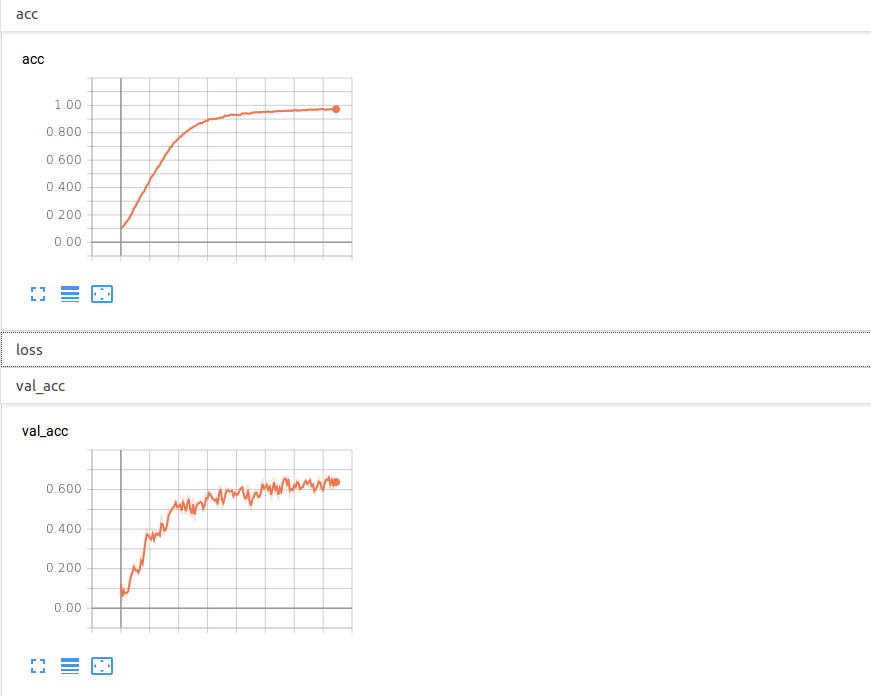